In [2]:
# for pytorch, data already in torchvision
import os
import tarfile
import urllib.request as url
import numpy as np
import torch

## load data
CIFAR already downloaded by tensorflow part

In [12]:
import glob
import _pickle as pickle
def load_data():
    if not os.path.exists('.././data/cifar-10-python.tar.gz'):
        download_data()
    if not os.path.exists('.././data/cifar-10-batches-py/'):
        print("extracting...")
        package = tarfile.open('.././data/cifar-10-python.tar.gz')
        package.extractall('.././data')
        package.close()
        
    root_dir = os.getcwd()
    os.chdir('.././data/cifar-10-batches-py')
    train_data = []
    train_label = []
    test_data = []
    test_label = []
    data_train = glob.glob('data_batch*')
    print(data_train)
    #try:
    for name in data_train:
        handle = open(name, 'rb')
        cmap = pickle.load(handle, encoding='bytes')
        train_data.append(cmap[b'data'])
        train_label.append(cmap[b'labels'])
        handle.close()
    # Turn the dataset into numpy compatible arrays.
    train_data = np.concatenate(train_data, axis=0)
    train_label = np.concatenate(train_label)
    handle = open('test_batch', 'rb')
    cmap = pickle.load(handle, encoding='bytes')
    test_data.append(cmap[b'data'])
    test_label.append(cmap[b'labels'])
    test_data = np.array(test_data[0])
    test_label = np.array(test_label[0])
    #except BaseException:
#         os.chdir(root_dir)
#         print('Something went wrong...')
#         return None
    os.chdir(root_dir)
    return train_data,train_label,test_data,test_label

train_data,train_label,test_data,test_label = load_data()
val_size = 1000
val_data = train_data[-1000:]
val_label = train_label[-1000:]
train_data = train_data[:-1000]
train_label = train_label [:-1000]
print(train_data.shape, train_label.shape)
print(val_data.shape, val_label.shape)
print(test_data.shape, test_label.shape)

train_data = train_data/255.
val_data = val_data/255.
test_data = test_data/255.

['data_batch_1', 'data_batch_4', 'data_batch_3', 'data_batch_2', 'data_batch_5']
(49000, 3072) (49000,)
(1000, 3072) (1000,)
(10000, 3072) (10000,)


In [4]:
# build net

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as func
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,16,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,64,5)
        self.fc1 = nn.Linear(64*5*5,328)
        self.fc2 = nn.Linear(328,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self, x):
        x = func.relu(self.conv1(x))
        x = self.pool(x)
        x = func.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*5*5)
        x = self.fc1(x)
        x = func.relu(x)
        x = self.fc2(x)
        x = func.relu(x)
        x = self.fc3(x)
        return x
net = Net()
net = net.cuda()

In [13]:
# loss func
import torch.optim as optim

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [14]:
train_data_r = train_data.reshape([-1,3,32,32])
# train_data_r = train_data_r.transpose([0,3,1,2])
train_data_r = train_data_r.astype(np.float32)
print(train_data_r.shape)
feed_data = Variable(torch.from_numpy(train_data_r[0:2]).cuda())
# print(feed_data)
print(net(feed_data))

print(train_label.reshape([1,train_label.shape[0]]))
train_label_h = np.zeros((train_label.shape[0],10))
train_label_h[np.arange(train_label.shape[0]), train_label] = 1
print(train_label_h[0])

train_label_r = train_label.astype(np.float32)



test_data_r = test_data.reshape([-1,3,32,32])
# train_data_r = train_data_r.transpose([0,3,1,2])
test_data_r = test_data_r.astype(np.float32)
print(test_data_r.shape)
feed_data = Variable(torch.from_numpy(test_data_r[0:2]).cuda())
# print(feed_data)
print(net(feed_data))

print(test_label.reshape([1,test_label.shape[0]]))
test_label_h = np.zeros((test_label.shape[0],10))
test_label_h[np.arange(test_label.shape[0]), test_label] = 1
print(test_label_h[0])

test_label_r = test_label


(49000, 3, 32, 32)
Variable containing:
 0.0647 -0.0302  0.0432  0.0514  0.0073 -0.0323 -0.0982  0.0084  0.0553 -0.0184
 0.0754 -0.0297  0.0398  0.0364 -0.0021 -0.0290 -0.1099  0.0219  0.0729 -0.0052
[torch.cuda.FloatTensor of size 2x10 (GPU 0)]

[[6 9 9 ..., 4 9 3]]
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
(10000, 3, 32, 32)
Variable containing:
 0.0767 -0.0394  0.0436  0.0435 -0.0009 -0.0263 -0.1055  0.0114  0.0606 -0.0118
 0.0785 -0.0336  0.0332  0.0311 -0.0044 -0.0303 -0.1124  0.0176  0.0777  0.0007
[torch.cuda.FloatTensor of size 2x10 (GPU 0)]

[[3 8 8 ..., 5 1 7]]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


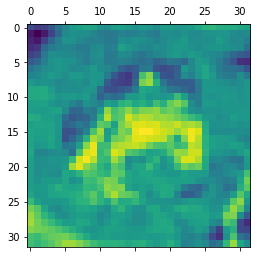

In [15]:
import matplotlib.pyplot as plt
samp = train_data[0].reshape([3,32,32])
# samp = samp[0,:,:]
#samp2 = train_data[0].reshape([32,32,3])
samp = samp.transpose([1,2,0])
plt.matshow(samp[:,:,0])
#plt.show()

In [20]:
batch_size = 100
for epoch in range(50):
    running_loss = 0.0
    for i in np.arange(0,train_data.shape[0]-batch_size,batch_size):
        inputs = torch.from_numpy(train_data_r[i:i+batch_size])
        labels = torch.from_numpy(train_label_r[i:i+batch_size]).type(torch.LongTensor)
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        if i/batch_size % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        if i == 0:
            val_acc()

Accuracy of the network on the 10000 test images: 63 %
[1,  9901] loss: 0.045
[1, 19901] loss: 0.047
[1, 29901] loss: 0.045
[1, 39901] loss: 0.047
Accuracy of the network on the 10000 test images: 64 %
[2,  9901] loss: 0.044
[2, 19901] loss: 0.046
[2, 29901] loss: 0.044
[2, 39901] loss: 0.046
Accuracy of the network on the 10000 test images: 64 %
[3,  9901] loss: 0.043
[3, 19901] loss: 0.044
[3, 29901] loss: 0.043
[3, 39901] loss: 0.045
Accuracy of the network on the 10000 test images: 64 %
[4,  9901] loss: 0.042
[4, 19901] loss: 0.043
[4, 29901] loss: 0.042
[4, 39901] loss: 0.044
Accuracy of the network on the 10000 test images: 65 %
[5,  9901] loss: 0.041
[5, 19901] loss: 0.042
[5, 29901] loss: 0.041
[5, 39901] loss: 0.043
Accuracy of the network on the 10000 test images: 65 %
[6,  9901] loss: 0.040
[6, 19901] loss: 0.041
[6, 29901] loss: 0.040
[6, 39901] loss: 0.042
Accuracy of the network on the 10000 test images: 65 %
[7,  9901] loss: 0.039
[7, 19901] loss: 0.040
[7, 29901] loss: 

In [21]:
def val_acc():
    correct = 0
    total = test_data.shape[0]
    #for i in np.arange(test_data.shape[0]):
    images = torch.from_numpy(test_data_r)
    labels = test_label
    images = Variable(images.cuda())
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    # return predicted
    correct += np.sum(Variable(predicted).data.cpu().numpy()
                      == labels)
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
m = val_acc()

Accuracy of the network on the 10000 test images: 65 %
